<a href="https://colab.research.google.com/github/tommasomora01/StockIndexClassification/blob/main/StockIndexClassification_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil
import os
directory = '/content/StockIndexClassification'

# Verifica se la directory esiste
if os.path.exists(directory):
    # Rimuovi la directory e il suo contenuto
    shutil.rmtree(directory)
    print(f'Directory "{directory}" rimossa.')
else:
    print(f'Directory "{directory}" non esiste.')
!git clone https://github.com/tommasomora01/StockIndexClassification.git
%run /content/StockIndexClassification/StockIndexClassification_COLABnew.ipynb

Directory "/content/StockIndexClassification" rimossa.
Cloning into 'StockIndexClassification'...
remote: Enumerating objects: 628, done.
remote: Counting objects: 100% (628/628), done.
remote: Compressing objects: 100% (456/456), done.
remote: Total 628 (delta 182), reused 596 (delta 166), pack-reused 0 (from 0)
Receiving objects: 100% (628/628), 10.75 MiB | 34.73 MiB/s, done.
Resolving deltas: 100% (182/182), done.


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/StockPrediction'
config_file_path = '/content/drive/MyDrive/StockPrediction/config.json'
folders = ['/content/drive/MyDrive/StockPrediction/models_saved', '/content/drive/MyDrive/StockPrediction/log_saved']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score

import pandas as pd

import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
from typing import (Tuple)
import numpy as np


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
            SPX Index    VIX  MOVE Index  10Y-2Y %  OAS HY\n( vs GOV)  \
Data                                                                    
2001-01-02  1299.3655  29.99      113.93   0.00054           0.086520   
2001-01-03  1364.6333  26.60      112.96   0.00229           0.085028   
2001-01-04  1350.2664  26.97      114.51   0.00252           0.085185   
2001-01-05  1314.8405  28.67      117.05   0.00362           0.085383   
2001-01-08  1312.5920  29.84      119.37   0.00396           0.085498   

              E_EXP    OIL  US Breakeven 10 Y  Return \n1 month  \
Data                                                              
2001-01-02  54.9447  27.21             1.3159         -0.023489   
2001-01-03  54.9537  28.00             1.5127          0.018017   
2001-01-04  54.9371  28.14             1.4614         -0.030449   
2001-01-05  54.9203  27.

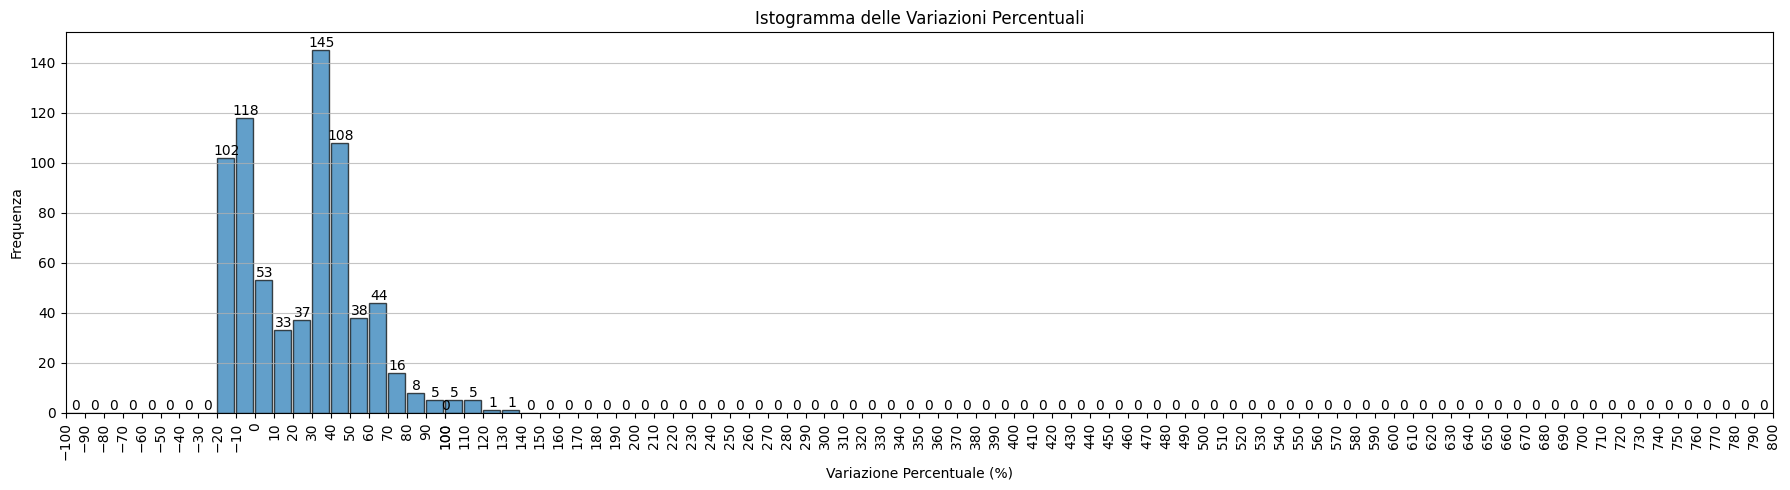

torch.Size([6, 90, 14])
torch.Size([6])
torch.Size([6, 90, 14])
torch.Size([6])


In [ ]:

dataset = pd.read_excel("/content/drive/MyDrive/StockPrediction/model_data.xlsx", sheet_name="DATA")

config = load_config(config_file_path)

dataset = dataset.set_index('Data')

cleared_dataset = dataset.dropna()


In [ ]:
year_start = config['dataset_params']['year_start']
month_start = config['dataset_params']['month_start']
year_end = config['dataset_params']['year_end']
month_end = config['dataset_params']['month_end']

dataset_handler = DatasetHandler(normalized_df,year_start=year_start,month_start=month_start,year_end=year_end,month_end=month_end)
train_model_dataset , _ = dataset_handler.split_dataset()

In [ ]:
train_inputs = train_model_dataset.iloc[:,:]
folders[0] = os.path.join(folders[0],"dataset_2019_2022")
folders[1] = os.path.join(folders[1],"dataset_2019_2022")
print(type(train_inputs))
print(train_inputs.shape)


X_train_tensor = torch.tensor(train_inputs.to_numpy())

print(type(X_train_tensor))

<class 'pandas.core.frame.DataFrame'>
(1174, 14)
<class 'torch.Tensor'>


In [ ]:
sequence_length = config['dataset_params']['sequence_length']
offset = config['dataset_params']['offset']
distance_pred = config['dataset_params']['distance_pred']
output_size = config['model_params']['output_size']
learning_rate = config['model_params']['learning_rate']
num_epochs = config['model_params']['num_epochs']
batch_size = config['model_params']['batch_size']

folders[0] = os.path.join(folders[0],f"{distance_pred}gg")
folders[1] = os.path.join(folders[1],f"{distance_pred}gg")

Num DOWN = 220, 30.598052851182196% (inf = 0) ;Num NEUTRAL = 181, 25.17385257301808%  ; Num UP = 318, 44.22809457579972% (sup = 35)


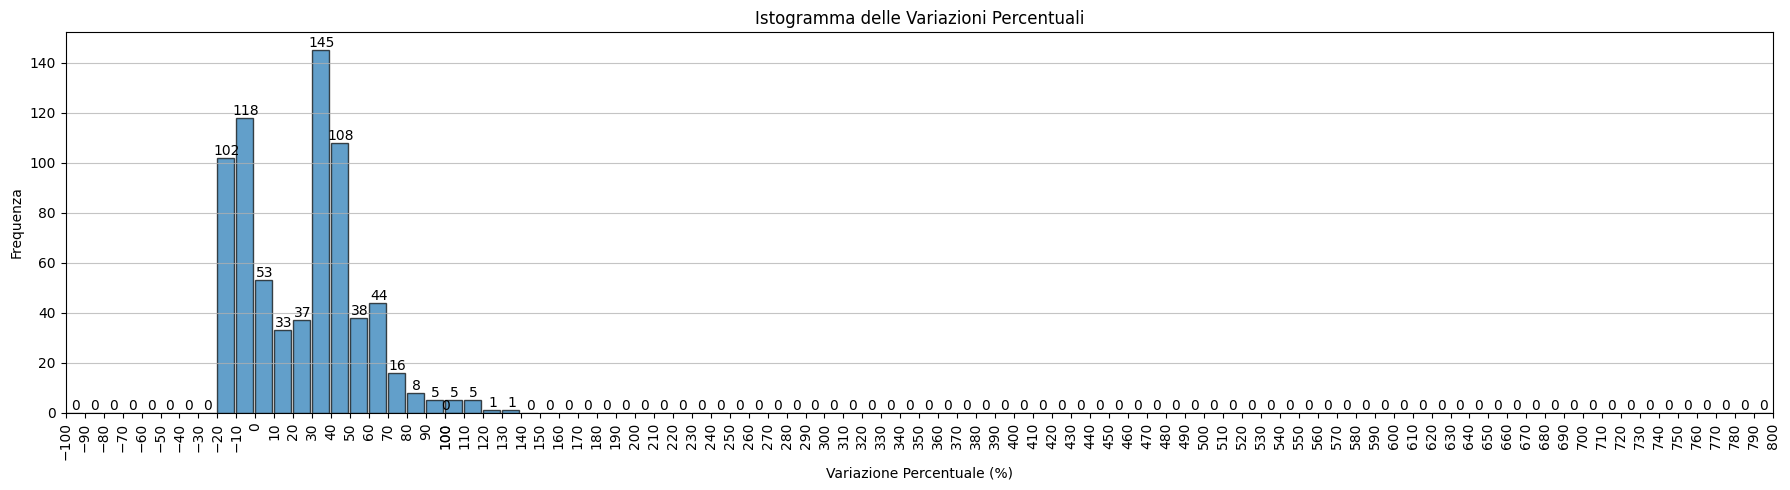

torch.Size([6, 90, 14])
torch.Size([6])
torch.Size([6, 90, 14])
torch.Size([6])


In [ ]:
dataset = SequenceDataset(train_inputs, sequence_length=sequence_length, offset=offset,distance_pred=distance_pred)
dataset.show_sequence(plot_mode=True)
# Split train-test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# Creazione dei DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for inputs in train_loader:
  print(inputs[0].shape)
  print(inputs[1].shape)
  break
for inputs in test_loader:
    print(inputs[0].shape)
    print(inputs[1].shape)
    break

In [ ]:
model_dim = config['model_params']['dimension']
d_model = config['model_params']['d_model']
n_head = config['model_params']['n_head']
dim_feedforward = config['model_params']['dim_feedforward']
num_layers = config['model_params']['num_layers']
kernel_size = config['model_params']['kernel_size']
early_stopping_patience = config['model_params']['early_stopping_patience']
early_stopping_delta = config['model_params']['early_stopping_delta']


In [ ]:
# Creazione del modello
model = TimeSeriesModel(train_inputs.shape[-1], output_size,"small",d_model = d_model, n_head= n_head, dim_feedforward= dim_feedforward, num_layers=num_layers, kernel_size=1)

for m in model.modules():
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ReLU activation
    if isinstance(m, (nn.TransformerEncoderLayer)):
        nn.init.xavier_uniform_(m.linear1.weight)
        nn.init.xavier_uniform_(m.linear2.weight)
print(f"train_inputs.shape[-1] =  {train_inputs.shape[-1]}")
print(f"output_size =  {output_size}")

print(model)


train_inputs.shape[-1] =  14
output_size =  3
TimeSeriesModel(
  (conv1): Conv1d(14, 32, kernel_size=(1,), stride=(1,), padding=same, padding_mode=reflect)
  (relu1): ReLU()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (relu2): ReLU()
  (classification_layer): Linear(in_features=32, out_features=3, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# # Definizione della loss e dell'optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(delta=early_stopping_delta, patience=early_stopping_patience)

In [ ]:
# Training del modello
for epoch in range(num_epochs):
    train_loss,stop = train_model(model, train_loader, test_loader, criterion, optimizer, device,early_stopping)
    #val_loss = evaluate_model(model, test_loader, device

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
    if stop:
        break

Epoch [1/1000], Loss: 1.1104
Epoch [2/1000], Loss: 1.0553
Epoch [3/1000], Loss: 1.0199
Epoch [4/1000], Loss: 0.9590
Epoch [5/1000], Loss: 0.8719
Epoch [6/1000], Loss: 0.7634
Epoch [7/1000], Loss: 0.6695
Epoch [8/1000], Loss: 0.6052
Epoch [9/1000], Loss: 0.5533
Epoch [10/1000], Loss: 0.5132
Epoch [11/1000], Loss: 0.4869
Epoch [12/1000], Loss: 0.4622
Epoch [13/1000], Loss: 0.4401
Epoch [14/1000], Loss: 0.4212
Epoch [15/1000], Loss: 0.4123
Epoch [16/1000], Loss: 0.3950
Epoch [17/1000], Loss: 0.3849
Epoch [18/1000], Loss: 0.3783
Epoch [19/1000], Loss: 0.3712
Epoch [20/1000], Loss: 0.3625
Epoch [21/1000], Loss: 0.3574
Epoch [22/1000], Loss: 0.3520
Epoch [23/1000], Loss: 0.3435
Epoch [24/1000], Loss: 0.3372
Epoch [25/1000], Loss: 0.3281
Epoch [26/1000], Loss: 0.3215
Epoch [27/1000], Loss: 0.3166
Epoch [28/1000], Loss: 0.3064
Epoch [29/1000], Loss: 0.3015
Epoch [30/1000], Loss: 0.2994
Epoch [31/1000], Loss: 0.2977
Epoch [32/1000], Loss: 0.2856
Epoch [33/1000], Loss: 0.2929


In [ ]:
# Valutazione del modello sul test set
test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
# #test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
print(f"Accuracy sul test set: {test_accuracy:.4f}")

all_predictions = 
[0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 2, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2, 0, 1, 1, 0, 1, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 0, 2, 0, 1, 1, 2]
all_targets = 
[0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 1, 2, 2, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 2, 0, 2, 2, 0, 0, 2, 1, 2, 1, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2, 0, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 1, 2, 0, 2, 0, 1, 1, 2]
Accuracy sul test set: 0.8611


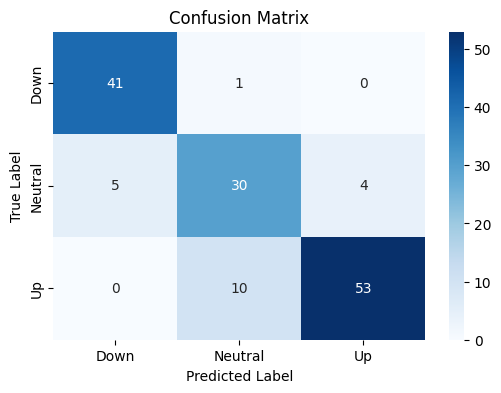

Matrice di Confusione:
[[41  1  0]
 [ 5 30  4]
 [ 0 10 53]]


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Calcolare la matrice di confusione
cm = confusion_matrix(all_targets, all_predictions)

# Visualizzare la matrice di confusione
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Neutral', 'Up'], yticklabels=['Down', 'Neutral', 'Up'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Stampa la matrice di confusione
print("Matrice di Confusione:")
print(cm)